## 📚 Prerequisites

Ensure that your Azure Services are properly set up, your Conda environment is created, and your environment variables are configured as per the instructions in the [SETTINGS.md](SETTINGS.md) file.


No custom model training: GPT-4 Vision is pre-trained and can extract structured data from various PDF document types without the need for custom training.
Schema flexibility: You can extract data with or without defining a schema, allowing for adaptability.
Complex document handling: GPT-4 Vision can handle complex documents containing tables, images, and non-standard elements

https://github.com/Azure-Samples/azure-openai-gpt-4-vision-pdf-extraction-sample/blob/main/Sample.ipynb

In [1]:
import os
import json

# Define the target directory
target_directory = r"C:\Users\pablosal\Desktop\gbbai-azure-ai-document-intelligence"  # change your directory here

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

Directory changed to C:\Users\pablosal\Desktop\gbbai-azure-ai-document-intelligence


## Document Intelligence

In [2]:
from src.ocr.document_intelligence import AzureDocumentIntelligenceManager

document_intelligence_client = AzureDocumentIntelligenceManager()

In [3]:
document_blob = "https://testeastusdev001.blob.core.windows.net/bills/Petr1.JPG"
model_type = "prebuilt-invoice"

result_ocr_invoice = document_intelligence_client.analyze_document(
    document_input=document_blob,
    model_type=model_type,
    output_format="markdown",
    features=["OCR_HIGH_RESOLUTION"],
)

2024-03-05 21:25:11,909 - micro - MainProcess - INFO     Blob URL detected. Extracting content. (document_intelligence.py:analyze_document:148)
2024-03-05 21:25:12,631 - micro - MainProcess - INFO     Successfully downloaded blob file Petr1.JPG (blob_data_extractor.py:extract_content:88)


In [4]:
data = document_intelligence_client.process_invoices(result_ocr_invoice)

In [5]:
data

[{'VendorName': {'content': 'Hotel Magnetberg Baden-Baden',
   'confidence': 0.917},
  'VendorAddress': {'content': 'Scheibenstr. 18\nD-76530 Baden-Baden',
   'confidence': 0.89},
  'VendorAddressRecipient': {'content': 'Hotel Magnetberg Baden-Baden',
   'confidence': 0.917},
  'CustomerName': {'content': None, 'confidence': None},
  'CustomerId': {'content': None, 'confidence': None},
  'CustomerAddress': {'content': None, 'confidence': None},
  'CustomerAddressRecipient': {'content': None, 'confidence': None},
  'InvoiceId': {'content': '108786', 'confidence': 0.93},
  'InvoiceDate': {'content': '24.04.2022', 'confidence': 0.933},
  'InvoiceTotal': {'content': '€', 'confidence': 0.345},
  'DueDate': {'content': None, 'confidence': None},
  'PurchaseOrder': {'content': None, 'confidence': None},
  'BillingAddress': {'content': None, 'confidence': None},
  'BillingAddressRecipient': {'content': None, 'confidence': None},
  'ShippingAddress': {'content': None, 'confidence': None},
  'Sh

## GPT4 + Vision

In [3]:
from src.ocr.transformer import GPT4VisionManager

gpt_vision_client = GPT4VisionManager()

In [4]:
sys_message = "You are an AI assistant capable of processing complex invoices and accurately extract relevant information from images."
user_prompt = """
Please analyze the provided invoice image and extract relevant information in accordance with the given fields. 
Identify the Vendor Name, Vendor Address, Invoice ID, Invoice Date, Service Start and End Dates, Items with their Descriptions, 
Dates, and Amounts. Return the extracted data in a JSON dictionary format. 
Ensure the Invoice ID is correctly extracted and matches the format expected for invoice IDs. 
Ensure to include the content for each field where applicable. 
For fields that are not available in the image, return 'None' for content. 
For the InvoiceTotal, take the sum of all individual item amounts.
For the Currency, ensure to identify the currency used in the invoice and ensure all monetary amounts are correctly interpreted in this currency. 
Calculate the Invoice Total by summing up the Amounts of all Items if not available, and verify that it matches the Invoice Total stated on the invoice. 
Identify the currency used in the invoice and ensure all monetary amounts are correctly interpreted in this currency.
All the amounts should be returned in the format "X,XXX.XX" without the currency symbol.
The Items should be extracted as an array of dictionaries, each representing an item line on the invoice with its details.

This task requires a high level of precision and attention to detail. Your ability to accurately extract and structure this data
is crucial for the subsequent processing and analysis of these invoices. Please take your time and ensure the highest level of accuracy.

Here is an example JSON structure that you would expect as a result. Remember your output should be in a proper JSON format that can be directly parsed by a computer program.

## Example JSON Structure
{
  "VendorName": {
    "content": "Hotel Magnetberg Baden-Baden",
  },
  "VendorAddress": {
    "content": "Scheibenstr. 18\nD-76530 Baden-Baden",
  },
  "VendorAddressRecipient": {
    "content": "Hotel Magnetberg Baden-Baden",
  },
  "CustomerName": {
    "content": None,
  },
  "CustomerId": {
    "content": None,
  },
  "CustomerAddress": {
    "content": None,
  },
  "CustomerAddressRecipient": {
    "content": None,
  },
  "InvoiceId": {
    "content": "108786",
  },
  "InvoiceDate": {
    "content": "24.04.2022",
  },
  "InvoiceTotal": {
    "content": "6,00",
  },
  "Currency": { 
    "content": "EUR",
  },
  "DueDate": {
    "content": None,
  },
  "PurchaseOrder": {
    "content": None,
  },
  "BillingAddress": {
    "content": None,
  },
  "BillingAddressRecipient": {
    "content": None,
  },
  "ShippingAddress": {
    "content": None,
  },
  "ShippingAddressRecipient": {
    "content": None,
  },
  "SubTotal": {
    "content": None,
  },
  "TotalTax": {
    "content": "6,00",
  },
  "PreviousUnpaidBalance": {
    "content": None,
  },
  "AmountDue": {
    "content": None,
  },
  "ServiceStartDate": {
    "content": "22.04.2022",
  },
  "ServiceEndDate": {
    "content": "24.04.2022",
  },
  "ServiceAddress": {
    "content": None,
  },
  "ServiceAddressRecipient": {
    "content": None,
  },
  "RemittanceAddress": {
    "content": None,
  },
  "RemittanceAddressRecipient": {
    "content": None,
  },
  "Items": [
    {
      "Description": {
        "content": "City tax",
      },
      "Date": {
        "content": "22.04.2022",
      },
      "Amount": {
        "content": "3,80",
      }
    }
    // ... other items
  ]
}
"""

In [5]:
document_blob = "C:\\Users\\pablosal\\Desktop\\gbbai-azure-ai-document-intelligence\\utils\data\\bills\\Petr1.JPG"

2024-03-05 21:31:36,790 - micro - MainProcess - INFO     Preparing instruction for GPT-4 Vision API call. (transformer.py:prepare_instruction:137)
2024-03-05 21:31:36,792 - micro - MainProcess - INFO     Instruction: [{'role': 'system', 'content': [{'type': 'text', 'text': 'You are an AI assistant capable of processing complex invoices and accurately extract relevant information from images.'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': '\nPlease analyze the provided invoice image and extract relevant information in accordance with the given fields. \nIdentify the Vendor Name, Vendor Address, Invoice ID, Invoice Date, Service Start and End Dates, Items with their Descriptions, \nDates, and Amounts. Return the extracted data in a JSON dictionary format. \nEnsure the Invoice ID is correctly extracted and matches the format expected for invoice IDs. \nEnsure to include the content for each field where applicable. \nFor fields that are not available in the image, return \'None
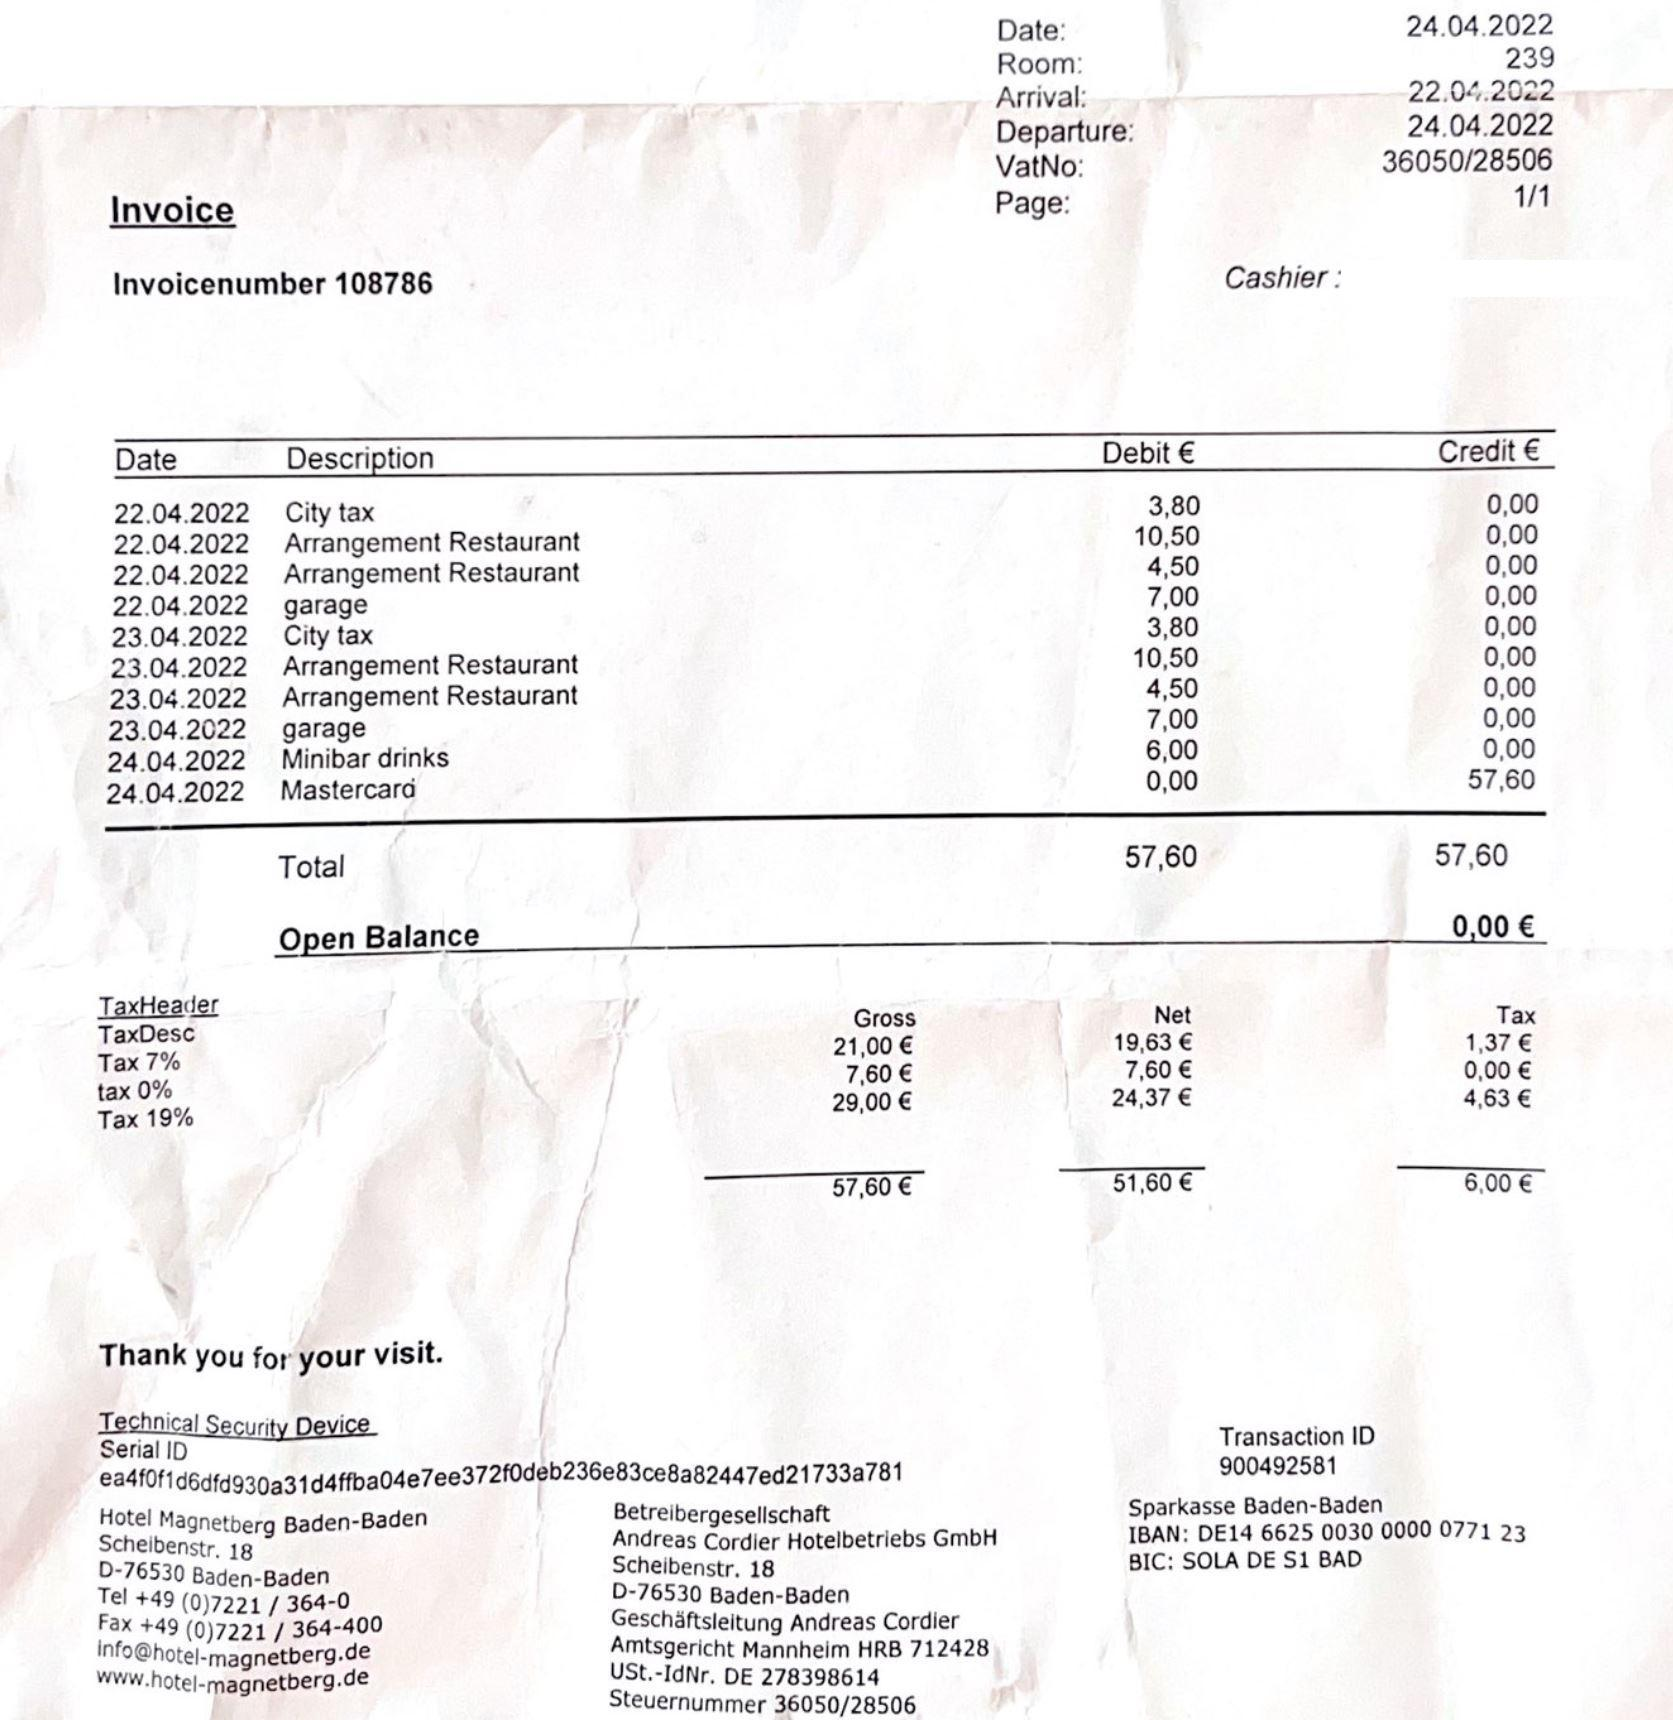

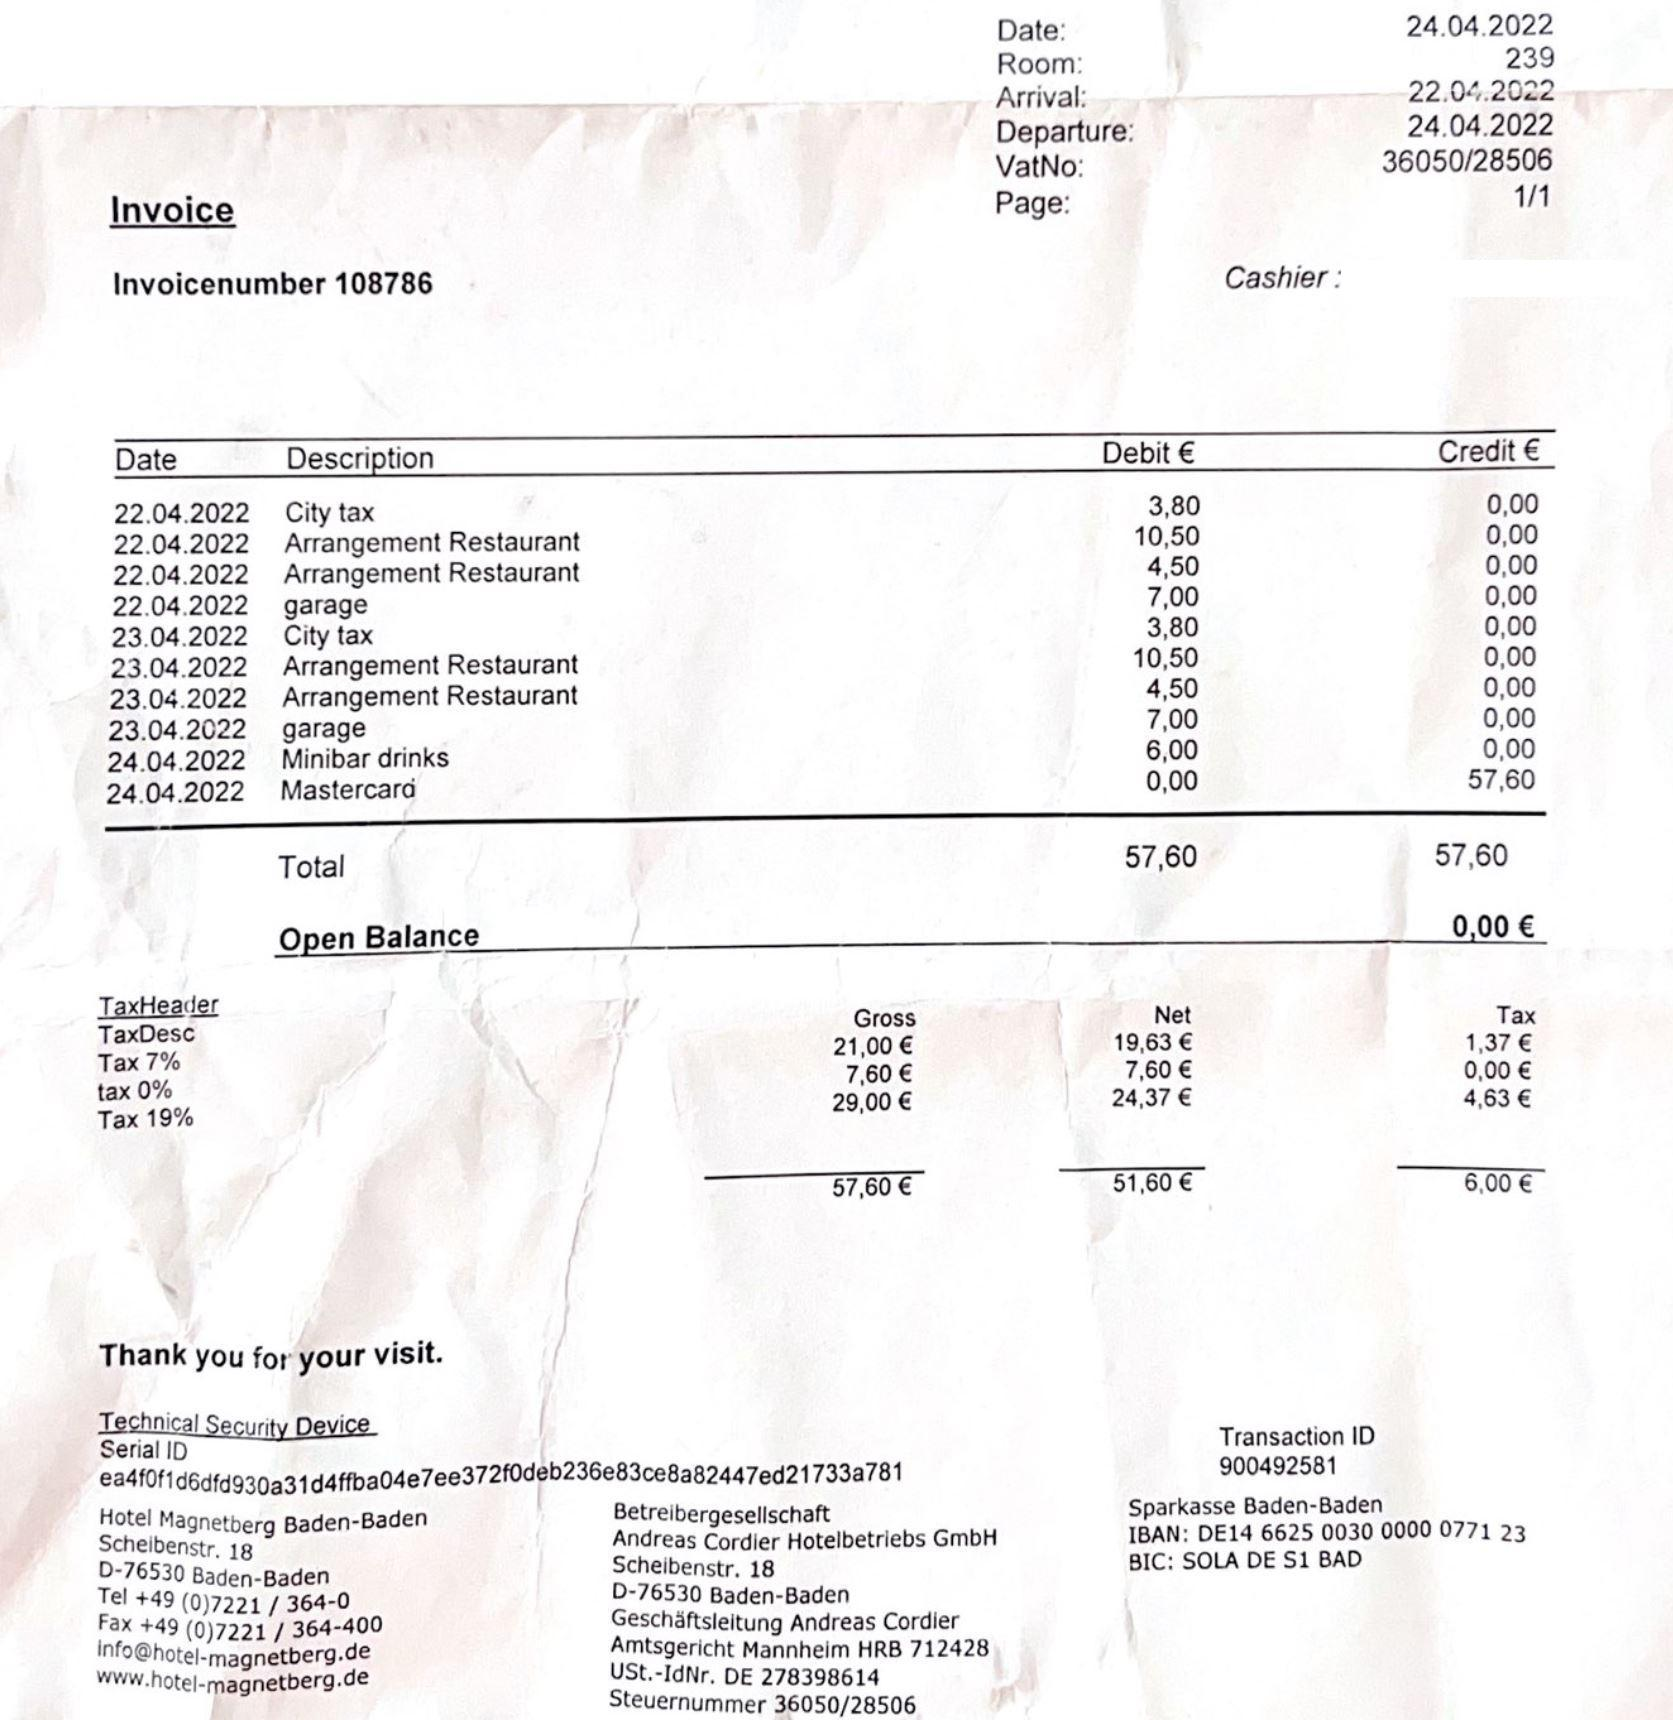

In [6]:
ocr_recognizer_1 = gpt_vision_client.call_gpt4v_image(
    document_blob,
    system_instruction=sys_message,
    user_instruction=user_prompt,
    ocr=True,
    use_vision_api=True,
    display_image=True,
    max_tokens=2000,
    seed=42,
)

In [7]:
ocr_recognizer_1

'```json\n{\n  "VendorName": {\n    "content": "Hotel Magnetberg Baden-Baden"\n  },\n  "VendorAddress": {\n    "content": "Scheibenstr. 18, D-76530 Baden-Baden"\n  },\n  "VendorAddressRecipient": {\n    "content": "Hotel Magnetberg Baden-Baden"\n  },\n  "CustomerName": {\n    "content": null\n  },\n  "CustomerId": {\n    "content": null\n  },\n  "CustomerAddress": {\n    "content": null\n  },\n  "CustomerAddressRecipient": {\n    "content": null\n  },\n  "InvoiceId": {\n    "content": "108786"\n  },\n  "InvoiceDate": {\n    "content": "24.04.2022"\n  },\n  "InvoiceTotal": {\n    "content": "57,60"\n  },\n  "Currency": {\n    "content": "EUR"\n  },\n  "DueDate": {\n    "content": null\n  },\n  "PurchaseOrder": {\n    "content": null\n  },\n  "BillingAddress": {\n    "content": null\n  },\n  "BillingAddressRecipient": {\n    "content": null\n  },\n  "ShippingAddress": {\n    "content": null\n  },\n  "ShippingAddressRecipient": {\n    "content": null\n  },\n  "SubTotal": {\n    "content":